In [7]:
from training import set_loader, set_model, parse_option
from retrieval import KNNClassifier
from demo import UofTData, plot_classes_preds, plot_imgs
import numpy as np
import torch

In [8]:
config = parse_option("--data_folder datasets --color_augmentation None --random False".split())
config.dataset = "GLRv2_5_preprocessed"
train_loader, val_loader, test_loader = set_loader(config)

config.dataset = "GLRv2_5_preprocessed_file_names"
train_loader_names, val_loader_names, test_loader_names = set_loader(config)

train_loader.dataset.transform = test_loader.dataset.transform

config.network = "efficientnet-b0"
efficientnet, _ = set_model(config, train_loader)
efficientnet.load_state_dict(torch.load("models/best_no_freeze_efficientnet-b0.pth")["model_state_dict"])
config.network = "senet-50"
se_resnet, _ = set_model(config, train_loader)
se_resnet.load_state_dict(torch.load("models/best_freeze_senet-50.pth")["model_state_dict"])
config.network = "swin"
swin, _ = set_model(config, train_loader)
swin.load_state_dict(torch.load("models/swin_best_lr0.001_nofreeze_bs32.pth")["model_state_dict"])

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [9]:
knn_model = KNNClassifier([efficientnet, se_resnet, swin], k=3)

In [10]:
# knn_model.create_embeddings(train_loader, train_loader_names)
# knn_model.save_embeddings("embeddings")
# load in the training set embeddings
knn_model.load_embeddings(
    ["embeddings\model_0_embeddings.npy",
    "embeddings\model_1_embeddings.npy",
    "embeddings\model_2_embeddings.npy",], 
    ["embeddings\model_0_labels.npy",
    "embeddings\model_1_labels.npy",
    "embeddings\model_2_labels.npy",],
    ["embeddings\model_0_fns.npy",
    "embeddings\model_1_fns.npy",
    "embeddings\model_2_fns.npy",])


In [11]:
acc_total = 0
num_samples = 0
for idx, (images, labels) in enumerate(test_loader):
    preds, images = knn_model.predict(images)
    num_samples += preds.shape[0]
    acc_total += np.sum(preds == labels.detach().numpy())
print(f"test acc is {acc_total/num_samples}")

test acc is 0.196


4578
This is wrong :(
3557
This is wrong :(
2177
This is wrong :(
3492
Hey it's correct!


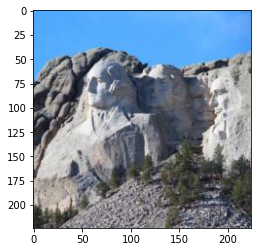

3497
This is wrong :(
4094
This is wrong :(
4478
This is wrong :(
3429
This is wrong :(
546
This is wrong :(
3190
This is wrong :(


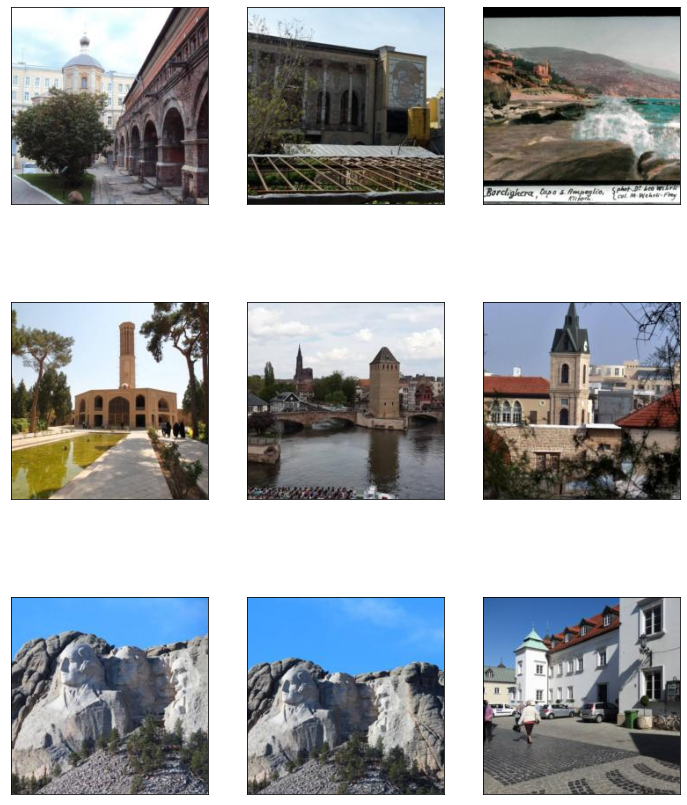

In [21]:
from numpy.random import MT19937
from numpy.random import RandomState
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

rs = RandomState(12345)
for _ in range(10):
    idx = rs.randint(0, len(test_loader.dataset))
    print(idx)
    (sample, label), (fn, _) = test_loader.dataset[idx], test_loader.dataset.imgs[idx]
    pred, top_classes_images = knn_model.predict(sample.unsqueeze(0))
    if pred == label:   
        print("Hey it's correct!")
        images_list = np.concatenate(top_classes_images, axis=0).flatten()
        img = mpimg.imread(fn)
        plt.imshow(img)
        plt.show()
        plot_imgs(images_list)
        
        
    else:
        print("This is wrong :(")


In [ ]:
dataset = UofTData("datasets", train=True)
dataset.transform = train_loader.dataset.transform
uoft_loader = torch.utils.data.DataLoader(
            dataset=dataset, 
            batch_size=config.batch_size, 
            num_workers=config.num_workers,)
uoft_loader_names = torch.utils.data.DataLoader(
            dataset=dataset.imgs, 
            batch_size=config.batch_size, 
            num_workers=config.num_workers,)

In [ ]:
knn_model.add_embeddings(uoft_loader, uoft_loader_names)

In [ ]:
test_dataset = UofTData("datasets", train=False)
test_dataset.transform = train_loader.dataset.transform
test_uoft_loader = torch.utils.data.DataLoader(
            dataset=dataset, 
            batch_size=config.batch_size, 
            num_workers=config.num_workers,)
acc_total = 0
num_samples = 0

for idx, (images, labels) in enumerate(test_uoft_loader):
    if idx > 1:
        break
    preds, images = knn_model.predict(images)
    num_samples += preds.shape[0]
    acc_total += np.sum(preds == labels.detach().numpy())
print(f"Accuracy for the UofT data is {acc_total/num_samples}")

test acc is 1.0
